# Notebook imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sys
import os
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from time import strftime
from keras.callbacks import TensorBoard

# Hyperparameter & Constants

In [2]:
params = {
    "batch_size": 32,
    "epochs": 1,
    "time_steps": 60
}

TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
EPOCH = params["epochs"]
LOG_DIR = 'tensorboard_summary'

# Gather Data

In [3]:
df = pd.read_csv('ge_stocks_us.csv')
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


# Visualizing Data

### Visualizing Open, Close, Low, High Price

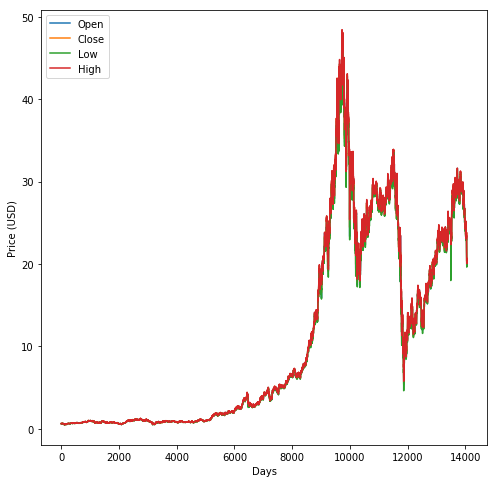

In [5]:
plt.figure(figsize=(8,8))
plt.plot(df["Open"])
plt.plot(df["Close"])
plt.plot(df["Low"])
plt.plot(df["High"])
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','Close','Low','High'], loc='upper left')
plt.show()

### Visualizing Volume

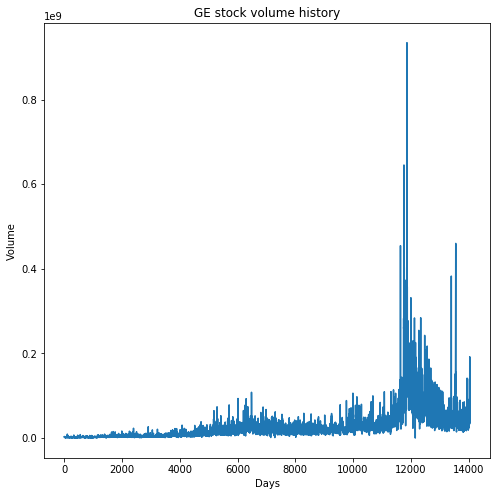

In [6]:
plt.figure(figsize=(8,8))
plt.plot(df["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

# Fun: Visualizing Moving Averages

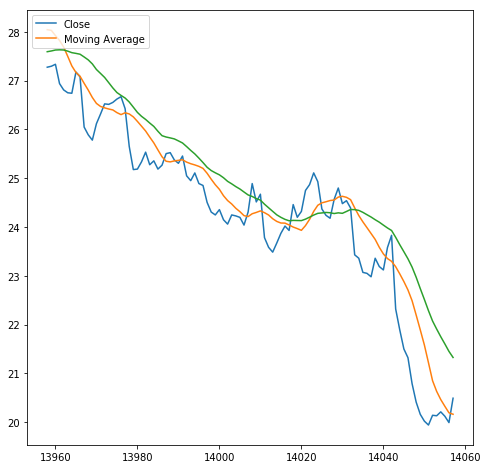

In [7]:
df['MA_window_10'] = df['Close'].rolling(10).mean().tail(100)
df['MA_window_20'] = df['Close'].rolling(20).mean().tail(100)

plt.figure(figsize=(8,8))
plt.plot(df["Close"].tail(100))
plt.plot(df["MA_window_10"].tail(100))
plt.plot(df["MA_window_20"].tail(100))
plt.legend(['Close', 'Moving Average'], loc='upper left')
plt.show()

# Cleaning data

In [8]:
# Cleaning data by checking null entry
df.isnull().any()

Date            False
Open            False
High            False
Low             False
Close           False
Volume          False
OpenInt         False
MA_window_10     True
MA_window_20     True
dtype: bool

# Split into training and testing set

### Extract all features except for date

In [9]:
features = df[['Low','High','Volume', 'Open', 'Close']]

### Split data into test and train data

In [10]:
x_train, x_test = train_test_split(features, train_size=0.8, test_size=0.2, shuffle=False)

In [11]:
print(f'Size of x_train: {x_train.shape}, Size of x_test: {x_test.shape}')

Size of x_train: (11246, 5), Size of x_test: (2812, 5)


# Normalize the training data

### Initialize minMax scaler instance

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))

### Transform data with minMax instance

In [14]:
scaled_x_train = scaler.fit_transform(x_train)
print(f"The Shape of scaled training data: {scaled_x_train.shape}")

The Shape of scaled training data: (11246, 5)


# Delete unused dataframe

In [15]:
print("Deleting unused dataframes of total size(KB)", sys.getsizeof(df)//1024)

Deleting unused dataframes of total size(KB) 1802


In [16]:
del df

# Build Time Series Data 

### Create 3D Time Series Data (Supervised data format) according to time steps 

In [17]:
# To create 3D array for LSTM model
# We convert the data into a 3D array with X_train samples, 60 timestamps, 
# and one feature at each step.

def build_time_series(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0, x.shape)
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [18]:
x_training, y_training = build_time_series(scaled_x_train, 4)

dim_0 11186 (11186, 60, 5)
length of time-series i/o (11186, 60, 5) (11186,)


In [19]:
print(f'The shape of time series features: {x_training.shape}, The Shape of time series labels: {y_training.shape}')

The shape of time series features: (11186, 60, 5), The Shape of time series labels: (11186,)


# Creating LSTM Model with Keras

### Visualizing model training with Tensorboard

In [20]:
def write_to_tensorboard(model_name):
    folder_name = f'{model_name} at { strftime("%H %M")}'
    dir_paths = os.path.join(LOG_DIR, folder_name)

    try:
        os.makedirs(dir_paths)
    except OSError as err:
        # Failure handler
        print(err.strerror)
    else:
        # Success handler
        print('Successfully created directory')
        
    return TensorBoard(log_dir=dir_paths)

### Define the model

In [21]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_training.shape[1], 5)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

Instructions for updating:
Colocations handled automatically by placer.


### Compile the model

In [22]:
model.compile(optimizer='adam',loss='mean_squared_error')

### Fit the model

In [26]:
# write_to_tensorboard function will be called ONCE only to return the Tensorboard Instance

model.fit(x_training, y_training, epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[write_to_tensorboard("model_1")])

Successfully created directory
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
11186/11186 [==============================] - 63s 6ms/step - loss: 0.0020


# Model Evaluation

### Normalize testing dataset with training set parameters

In [27]:
scaled_x_test = scaler.transform(x_test)
print(f'The shape of normalized testing set: {scaled_x_test.shape}')

The shape of normalized testing set: (2812, 5)


### Convert testing data to time series data according to time steps

In [28]:
x_testing, y_testing = build_time_series(scaled_x_test, 4)
print(f'The shape of normalized testing features: {x_testing.shape}')
print(f'The shape of normalized testing labels: {y_testing.shape}')

dim_0 2752 (2752, 60, 5)
length of time-series i/o (2752, 60, 5) (2752,)
The shape of normalized testing features: (2752, 60, 5)
The shape of normalized testing labels: (2752,)


### Predict using testing features

In [29]:
predicted_y_testing = model.predict(x_testing)

In [30]:
print(f'The shape of predicted values (close price): {predicted_y_testing.shape}')

The shape of predicted values (close price): (2752, 1)


### Create a placeholder to hold predicted values for inverse transform

In [31]:
y_col_index = 4
placeholder = np.zeros([predicted_y_testing.shape[0], y_col_index])
predicted_y_testing = np.concatenate([placeholder, predicted_y_testing], axis=1)

### Inverse normalization/transform using parameters from training data

In [32]:
predicted_y_testing = scaler.inverse_transform(predicted_y_testing)

### Extract all the predicted close prices

In [33]:
predicted_y_testing[:, y_col_index]

array([27.75680048, 27.72917944, 27.69263886, ..., 19.99852595,
       19.96268612, 19.96466351])

### Plot the actual price and predicted price

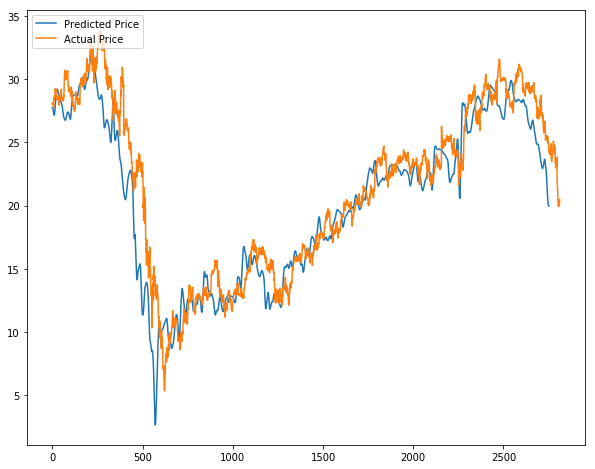

In [34]:
# Actual price (testing label)
y_testing = scaler.inverse_transform(scaled_x_test)[:,y_col_index]

# Predicted price 
y_predicted = predicted_y_testing[:,y_col_index]

plt.figure(figsize=(10,8))
plt.plot(y_predicted)
plt.plot(y_testing)
plt.legend(['Predicted Price', 'Actual Price'], loc='upper left')
plt.show()